# Image retrieval with prompts

In this notebook, we explore how to use CLIP to retrieve images using prompts.
We will apply the following steps:
* Install required packages
* Load a dataset (CIFAR10 here)
* Extract the embeddings of the images and store them in a FAISS index
* Compute embedding for a given prompt (e.g. a cat)
* Retrieve top-k images similar to the given prompt

## Install required packages

In [ ]:
pip install transformers Pillow torch faiss-gpu datasets


## Load CLIP: model, processor and tokenizer using transformers

In [ ]:
#Import packages
import torch
from PIL import Image
from transformers import AutoProcessor, CLIPModel, AutoImageProcessor, AutoModel, AutoTokenizer
import faiss
import numpy as np

#Define device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

#Load CLIP model, processor and tokenizer
processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")

## Load CIFAR 10 dataset
We use this dataset as it is rather small for this demo

Found cached dataset cifar10 (/home/alm/.cache/huggingface/datasets/cifar10/plain_text/1.0.0/447d6ec4733dddd1ce3bb577c7166b986eaa4c538dcd9e805ba61f35674a9de4)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 99.31it/s]


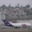

In [3]:
from datasets import load_dataset

#Load cifar10 dataset
dataset = load_dataset("cifar10")

#Display an image
display(dataset['train'][0]['img'])

## Keep only train set and limit its size

In [8]:
#Limit dataset to 1000 images
from datasets import Dataset
train_dataset = dataset["train"].filter(lambda example, idx: idx < 1000, with_indices=True)
print(train_dataset)

Loading cached processed dataset at /home/alm/.cache/huggingface/datasets/cifar10/plain_text/1.0.0/447d6ec4733dddd1ce3bb577c7166b986eaa4c538dcd9e805ba61f35674a9de4/cache-58a30656b0cdc8e9.arrow


Dataset({
    features: ['img', 'label'],
    num_rows: 1000
})


## Define function to extract features, convert them into numpy array and store into CLIP

In [11]:
#Add a vector to FAISS index
def add_vector_to_index(embedding, index):
    #convert embedding to numpy
    vector = embedding.detach().cpu().numpy()
    #Convert to float32 numpy
    vector = np.float32(vector)
    #Normalize vector: important
    faiss.normalize_L2(vector)
    #Add to index
    index.add(vector)

#Extract features of a given image
def extract_features_clip(image):
    with torch.no_grad():
        inputs = processor(images=image, return_tensors="pt").to(device)
        image_features = model.get_image_features(**inputs)
        return image_features

#FAISS index
index = faiss.IndexFlatL2(512)

#Process the dataset to extract all features and store in index
for image in train_dataset:
    clip_features = extract_features_clip(image['img'])
    add_vector_to_index(clip_features,index)
    
#Write index locally. Not needed after but can be useful for future retrieval
faiss.write_index(index,"clip.index")

## Search with a prompt

In [12]:
prompt="a photo of a cat"

#Tokenize the prompt and extract features
text_token = tokenizer([prompt], return_tensors="pt").to(device)
text_features = model.get_text_features(**text_token)

#Preprocess the vector before search in FAISS index
text_np = text_features.detach().cpu().numpy()
text_np = np.float32(text_np)
faiss.normalize_L2(text_np)

#Search the top 5 images
distances, indices = index.search(text_np, 5)

#distances is an array of rray with all the L2 distances for each top-5 results
#indices is the list of indices for the top-5 results in the dataset
print('distances',distances)
print('indices' ,indices)

distances [[1.426615  1.4340438 1.4355334 1.4399614 1.4402148]]
indices [[735 721 611 361 742]]


## Display results and similarity score

Indice: 735 , Similarity score: 41.209668616336806


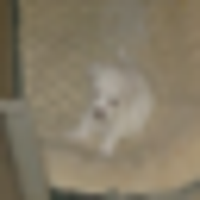

Indice: 721 , Similarity score: 41.08389562880521


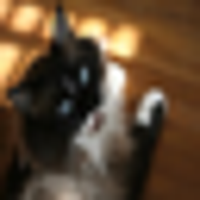

Indice: 611 , Similarity score: 41.058767587167075


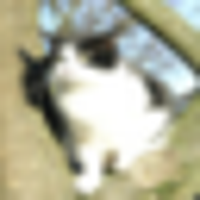

Indice: 361 , Similarity score: 40.9842543536507


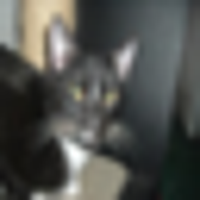

Indice: 742 , Similarity score: 40.97999976062536


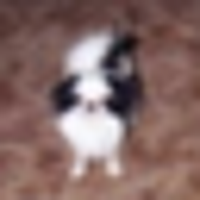

In [14]:
#For each top-5 results, compute similarity score between 0 and 1, print indice, similarity score and display image 
for i,v in enumerate(indices[0]):
    sim = (1/(1+distances[0][i])*100)
    print(f"Indice: {v} , Similarity score: {sim}")
    img_resized = train_dataset[int(v)]['img'].resize((200, 200))
    display(img_resized)